## Vikas Chaudhary
### MDS202353

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install -q split-folders

In [ ]:
!pip install bing-image-downloader

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

In [ ]:
from bing_image_downloader import downloader
downloader.download("chicken bird", limit=100, output_dir='images', adult_filter_off=True, force_replace=False, timeout=60)
downloader.download("duck bird", limit=100, output_dir='images', adult_filter_off=True, force_replace=False, timeout=60)


[%] Downloading Images to /content/images/chicken bird


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://pixnio.com/free-images/2020/07/03/2020-07-03-10-41-06.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.thoughtco.com/thmb/kAa1KovfJfcpMICKMPXoHF5IhuM=/2500x1674/filters:fill(auto,1)/red_junglefowl-5968fedd5f9b582c356ab7fb.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://cdn.britannica.com/18/137318-050-29F7072E/rooster-Rhode-Island-Red-roosters-chicken-domestication.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://cdn.pixabay.com/photo/2014/07/31/13/36/chicken-406312_1280.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.pinimg.com/originals/f2/77/d2/f277d2162da9af687fa7182f8dd2ecca.png
[%] File Downloaded !

[%] Downloading Image #6 from https://cdn.pixabay.com/photo/2021/01/07/06/43/hen-5896345_1280.jpg
[%] File Downloaded !

[%] Downloading Image #7 from https://pix

In [ ]:
import os

# Rename folders to "chicken" and "duck"
os.rename('images/chicken bird', 'images/chicken')
os.rename('images/duck bird', 'images/duck')

In [ ]:
import splitfolders

# Now the path is valid and matches expected format
splitfolders.ratio('images', output="dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 200 files [00:00, 1972.18 files/s]


In [ ]:
import os

for root, dirs, files in os.walk("dataset", topdown=True):
    for name in dirs:
        print(os.path.join(root, name))


dataset/val
dataset/train
dataset/test
dataset/val/chicken
dataset/val/duck
dataset/train/chicken
dataset/train/duck
dataset/test/chicken
dataset/test/duck


In [ ]:
# Save dataset to Google Drive
!cp -r /content/dataset /content/drive/MyDrive/chicken_duck_dataset/

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val = val_test_datagen.flow_from_directory(
    "dataset/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test = val_test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

Found 159 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


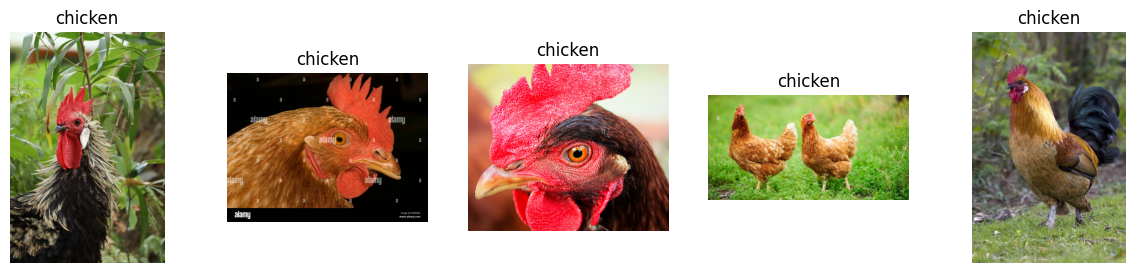

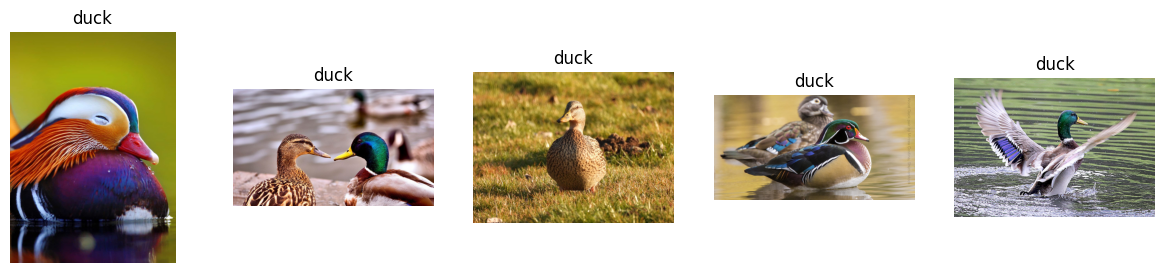

In [ ]:
def show_samples(base_path, class_name, n=5):
    path = os.path.join(base_path, class_name)
    images = random.sample(os.listdir(path), n)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Show 5 samples from training set
show_samples("dataset/train", "chicken")
show_samples("dataset/train", "duck")

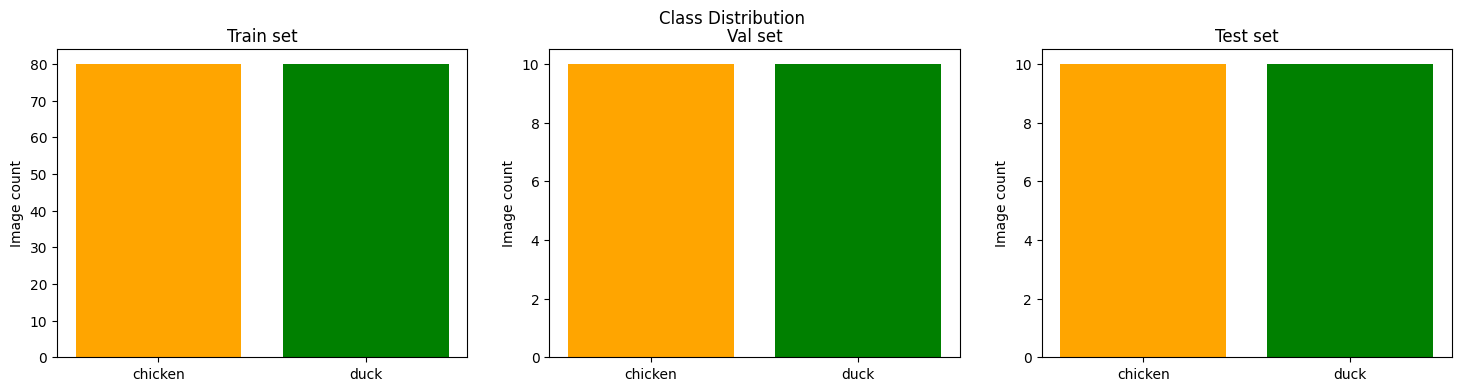

In [ ]:
def count_images(folder):
    counts = {}
    for label in ['chicken', 'duck']:
        label_dir = os.path.join(folder, label)
        counts[label] = len(os.listdir(label_dir))
    return counts

splits = ['train', 'val', 'test']
dist_data = {}

for split in splits:
    dist_data[split] = count_images(f"dataset/{split}")

# Plot
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i, split in enumerate(splits):
    ax[i].bar(dist_data[split].keys(), dist_data[split].values(), color=['orange', 'green'])
    ax[i].set_title(f'{split.capitalize()} set')
    ax[i].set_ylabel("Image count")
plt.suptitle("Class Distribution")
plt.show()

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 4/10 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.7513 - loss: 0.5011

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8566 - loss: 0.3588 - val_accuracy: 1.0000 - val_loss: 0.0345
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 808ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 680ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0032


In [ ]:
# Predict on test set
pred_probs = model.predict(test)
pred_classes = (pred_probs > 0.5).astype("int32")

# True labels
true_classes = test.classes
class_labels = list(test.class_indices.keys())

# Classification Report
print(classification_report(true_classes, pred_classes, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
              precision    recall  f1-score   support

     chicken       1.00      1.00      1.00        10
        duck       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Assignment Summary: Chicken vs Duck Image Classification Using Transfer Learning

- Collected approximately 100 images each of chickens and ducks using the `bing-image-downloader` library.
- Organized the dataset into training, validation, and test sets using an 80/10/10 split.
- Backed up the dataset to Google Drive for persistence.
- Used **MobileNetV2** as the base model for transfer learning (pre-trained on ImageNet).
- Removed the original classification head and added:
  - Global Average Pooling layer  
  - Dense layer with ReLU activation  
  - Output layer with sigmoid activation for binary classification
- Kept the base MobileNetV2 layers frozen during training (used as a fixed feature extractor).
- Compiled the model using the **Adam optimizer** and **binary cross-entropy** loss.
- Trained the model using image generators with basic data augmentation.
- Evaluated model performance using a **classification report** (precision, recall, F1-score, and accuracy).
- Visualized a few sample images and plotted the class distribution for all data splits.
- Demonstrated the effectiveness of **transfer learning** for small-scale image classification tasks.
